## Introduction

Consider the following system:
$$\frac{dx}{dt}=-x-y-x^{2}$$
$$\frac{dy}{dt}=x-y-y^{2}$$

We solve for equilibrium: $(0,0)$ and (numerical approximate) $(0.83928, -1.54368)$. By linearization near the equilibrium and computing the Jacobian matrix, $(0,0)$ is a spiral sink and $(0.83928, -1.54368)$ is a saddle. We are interested to approximate the basin of attraction of $(0,0)$.

In [6]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from tqdm import tqdm

In [2]:
def system(t, X):
    x, y = X
    xp = -x-y-x*x
    yp = x-y-y*y
    return xp, yp

/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_61188/2502684936.py:7: RuntimeWarning: invalid value encountered in divide
  U = U / N
/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_61188/2502684936.py:8: RuntimeWarning: invalid value encountered in divide
  V = V / N


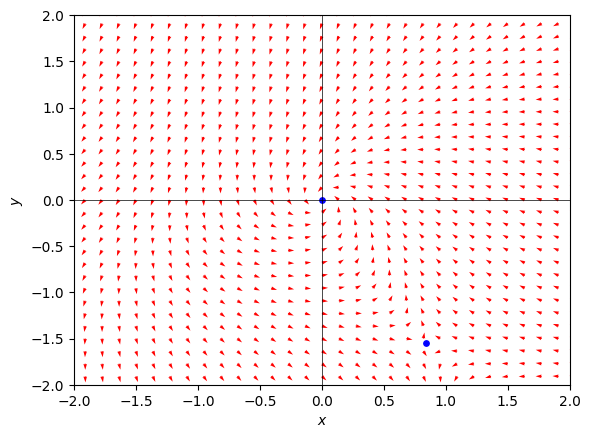

In [3]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.83928], [0, -1.54368], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

## Generate datasets

In [4]:
## Generate 100,000 uniformly sampled points in the square [-2, 2] x [-2, 2]
np.random.seed(0)
X = np.random.uniform(-2, 2, 100000)
Y = np.random.uniform(-2, 2, 100000)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))
spiral_sink = (0, 0)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), spiral_sink) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


In [7]:
# Create the dataset
df = pd.DataFrame(columns=['x0', 'y0', 'attracted'])
for i in tqdm(range(100000)):  # wrap range with tqdm for progress bar
    x0, y0 = X[i], Y[i]
    attracted_result = simulation(x0, y0)
    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
    df.loc[i] = [x0, y0, attracted_result]

# Save the DataFrame to a CSV file
df.to_csv('dataset_arbi2d.csv', index=False)

100%|██████████| 100000/100000 [59:30<00:00, 28.01it/s] 


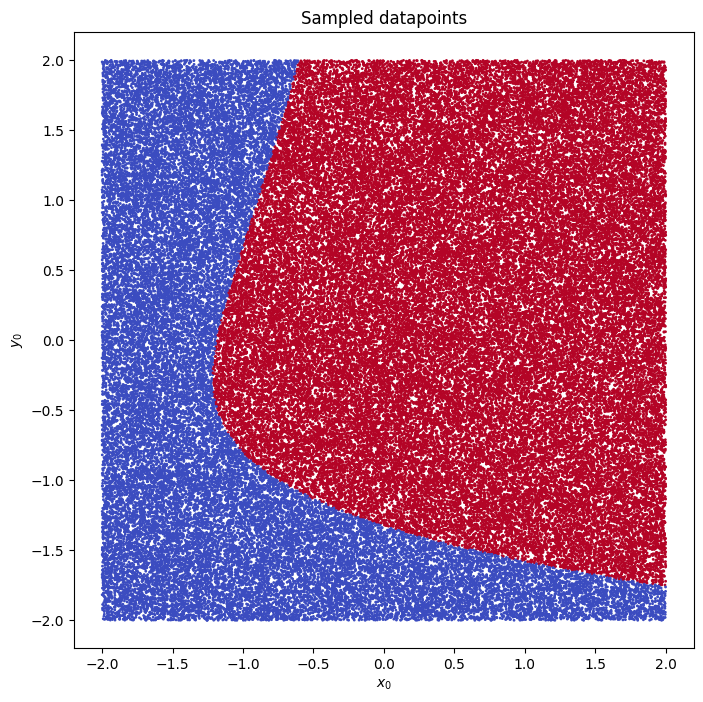

In [13]:
## Plot the sampled datapoints
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

In [9]:
## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.01): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

In [11]:
df_1 = df[df['attracted'] == 1].sample(100)
df_n1 = df[df['attracted'] == -1].sample(100)

dataset_near = []
for i in tqdm(range(len(df_1)), desc="Processing df_1"):
    for j in range(len(df_n1)):
        a = (df_1.iloc[i]['x0'], df_1.iloc[i]['y0'])
        b = (df_n1.iloc[j]['x0'], df_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_arbi2d_near.csv', index=False)

Processing df_1: 100%|██████████| 100/100 [41:07<00:00, 24.68s/it]


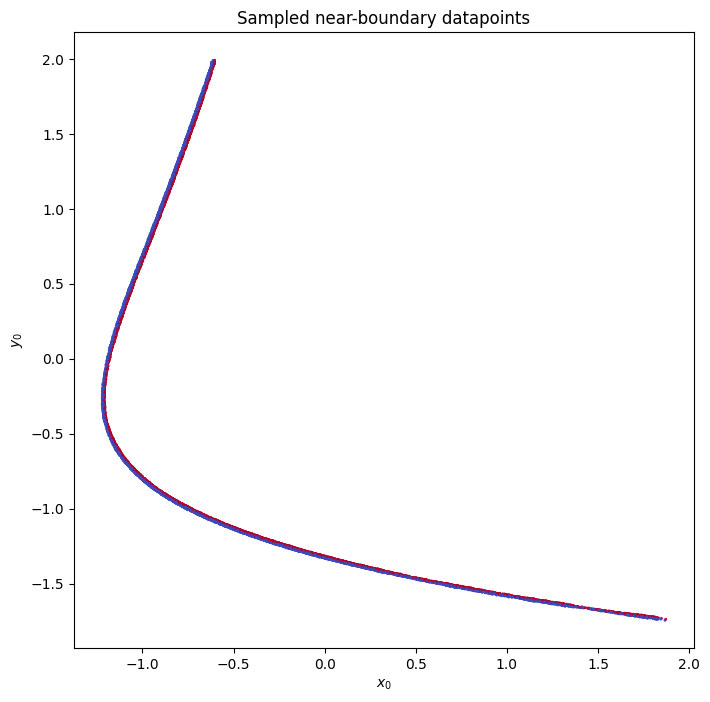

In [14]:
## Verify the generated near-boundary points
plt.figure(figsize=(8, 8))
plt.scatter(df_near['x0'], df_near['y0'], c=df_near['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled near-boundary datapoints')
plt.show()

In [15]:
## Verify the generated near-boundary points
df_near_1 = df_near[df_near['attracted'] == 1]
df_near_n1 = df_near[df_near['attracted'] == -1]

for i, row in tqdm(df_near_1.iterrows(), total=df_near_1.shape[0]):
    if not simulation(row['x0'], row['y0']):
        print(f"Error: {row['x0']}, {row['y0']}")
print("Done with label 1")

for i, row in tqdm(df_near_n1.iterrows(), total=df_near_n1.shape[0]):
    if simulation(row['x0'], row['y0']):
        print(f"Error: {row['x0']}, {row['y0']}")
print("Done with label -1")

100%|██████████| 10000/10000 [05:04<00:00, 32.79it/s]


Done with label 1


100%|██████████| 10000/10000 [02:11<00:00, 75.95it/s]

Done with label -1


## Model training

In [16]:
class SystemDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y



dataset_uniform = SystemDataset("dataset_arbi2d.csv") ## 100,000 points
dataset_near = SystemDataset("dataset_arbi2d_near.csv") ## 20,000 points

dataset_uniform_train, dataset_uniform_test = torch.utils.data.random_split(dataset_uniform, [80000, 20000])
dataset_near_train, dataset_near_test = torch.utils.data.random_split(dataset_near, [16000, 4000])
dataset_merged_train = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
dataset_merged_test = torch.utils.data.ConcatDataset([dataset_uniform_test, dataset_near_test])

In [17]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net = Net()

In [18]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude, threshold):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude
        self.threshold = threshold

    def forward(self, predictions, labels, inputs, b):
        l = nn.BCELoss()
        l = l(predictions.squeeze(), labels)

        near_condition = (predictions > 0.5 - self.threshold) & (predictions < 0.5 + self.threshold)
        near_points_prediction = predictions[near_condition]
        near_points_input = inputs[near_condition].clone().detach().requires_grad_(True)
        grads = torch.autograd.grad(near_points_prediction.sum(), near_points_input, create_graph=True, allow_unused=True)[0]
        
        if grads is not None:
            norm_grads = grads / grads.norm(dim = 1, keepdim=True)
            norm_b = b / b.norm(dim=1, keepdim=True)
            inner_product = (norm_grads * norm_b).sum(dim=1)
            inner_product = inner_product ** 2
            l += self.magnitude * inner_product
        
        return l

In [44]:
def train_model_bce(net, dataset_train, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net
    
def train_model_custom(net, dataset_train, batchsize, epochs, lr, magnitude, threshold):
    criterion = CustomLoss(magnitude, threshold)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, system(0, features.T))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net

def test_model(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm')

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()

    plt.hist(probability, bins=20)
    plt.show()

In [20]:
net_bce_uniform = Net()
net_bce_uniform = train_model_bce(net, dataset_uniform_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.068
Finished training for epoch 2, loss: 0.018
Finished training for epoch 3, loss: 0.013
Finished training for epoch 4, loss: 0.011
Finished training for epoch 5, loss: 0.010
Finished training for epoch 6, loss: 0.010
Finished training for epoch 7, loss: 0.009
Finished training for epoch 8, loss: 0.009
Finished training for epoch 9, loss: 0.008
Finished training for epoch 10, loss: 0.009


In [21]:
net_custom_uniform = Net()
net_custom_uniform = train_model_custom(net, dataset_uniform_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.008
Finished training for epoch 2, loss: 0.008
Finished training for epoch 3, loss: 0.008
Finished training for epoch 4, loss: 0.008
Finished training for epoch 5, loss: 0.008
Finished training for epoch 6, loss: 0.008
Finished training for epoch 7, loss: 0.007
Finished training for epoch 8, loss: 0.007
Finished training for epoch 9, loss: 0.008
Finished training for epoch 10, loss: 0.007


In [22]:
net_bce_near = Net()
net_bce_near = train_model_bce(net, dataset_near_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.531
Finished training for epoch 2, loss: 0.526
Finished training for epoch 3, loss: 0.517
Finished training for epoch 4, loss: 0.517
Finished training for epoch 5, loss: 0.509
Finished training for epoch 6, loss: 0.507
Finished training for epoch 7, loss: 0.496
Finished training for epoch 8, loss: 0.495
Finished training for epoch 9, loss: 0.499
Finished training for epoch 10, loss: 0.497


In [23]:
net_custom_near = Net()
net_custom_near = train_model_custom(net, dataset_near_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.482
Finished training for epoch 2, loss: 0.474
Finished training for epoch 3, loss: 0.472
Finished training for epoch 4, loss: 0.485
Finished training for epoch 5, loss: 0.474
Finished training for epoch 6, loss: 0.461
Finished training for epoch 7, loss: 0.464
Finished training for epoch 8, loss: 0.455
Finished training for epoch 9, loss: 0.453
Finished training for epoch 10, loss: 0.455


In [24]:
net_bce_merged = Net()
net_bce_merged = train_model_bce(net, dataset_merged_train, 32, 10, 0.001)

Finished training for epoch 1, loss: 0.090
Finished training for epoch 2, loss: 0.089
Finished training for epoch 3, loss: 0.088
Finished training for epoch 4, loss: 0.088
Finished training for epoch 5, loss: 0.087
Finished training for epoch 6, loss: 0.088
Finished training for epoch 7, loss: 0.086
Finished training for epoch 8, loss: 0.086
Finished training for epoch 9, loss: 0.085
Finished training for epoch 10, loss: 0.085


In [25]:
net_custom_merged = Net()
net_custom_merged = train_model_custom(net, dataset_merged_train, 32, 10, 0.001, 0.1, 0.1)

Finished training for epoch 1, loss: 0.085
Finished training for epoch 2, loss: 0.085
Finished training for epoch 3, loss: 0.082
Finished training for epoch 4, loss: 0.082
Finished training for epoch 5, loss: 0.082
Finished training for epoch 6, loss: 0.083
Finished training for epoch 7, loss: 0.085
Finished training for epoch 8, loss: 0.081
Finished training for epoch 9, loss: 0.081
Finished training for epoch 10, loss: 0.081


Accuracy: 0.9995999932289124


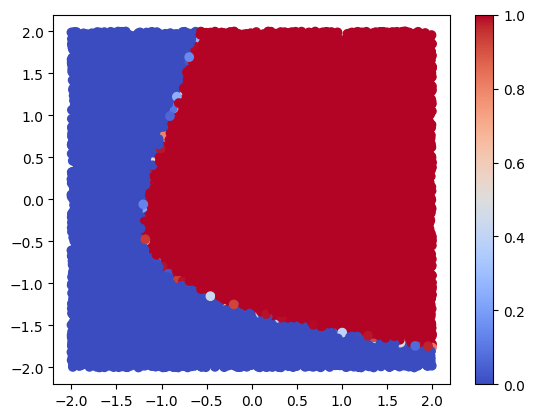

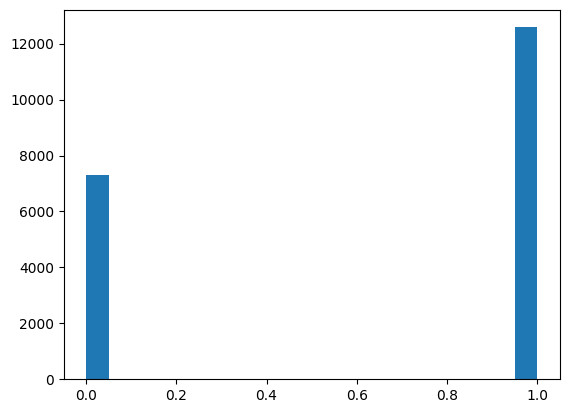

In [45]:
## net_bce_uniform
test_model(net_bce_uniform, dataset_uniform_test)

Accuracy: 0.8872500061988831


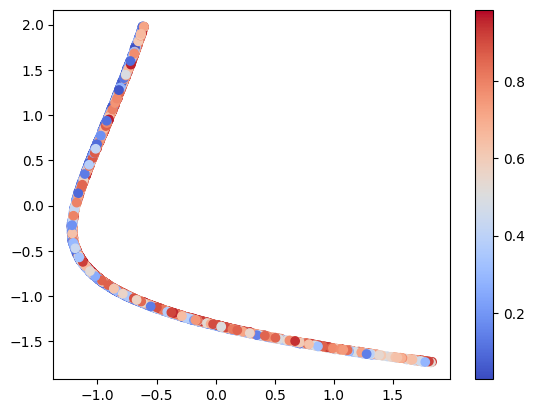

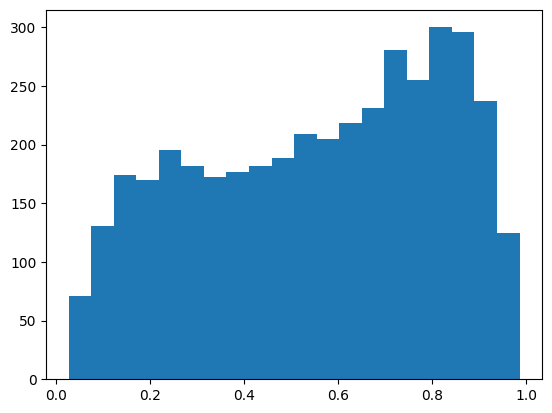

In [46]:
test_model(net_bce_uniform, dataset_near_test)

Accuracy: 0.9808750152587891


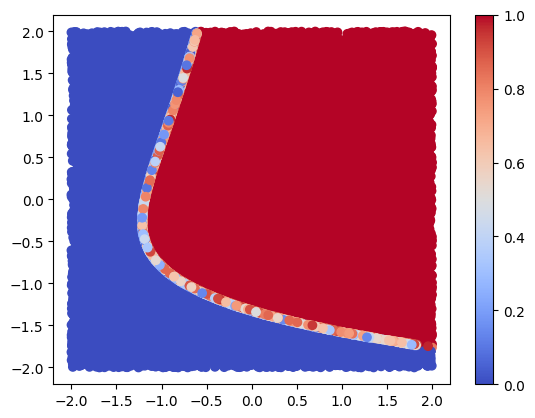

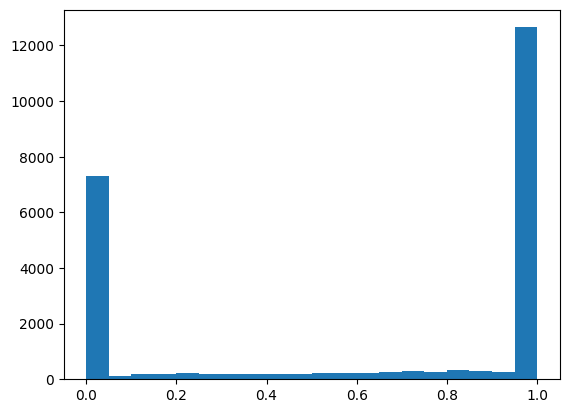

In [47]:
test_model(net_bce_uniform, dataset_merged_test)

Accuracy: 0.9995999932289124


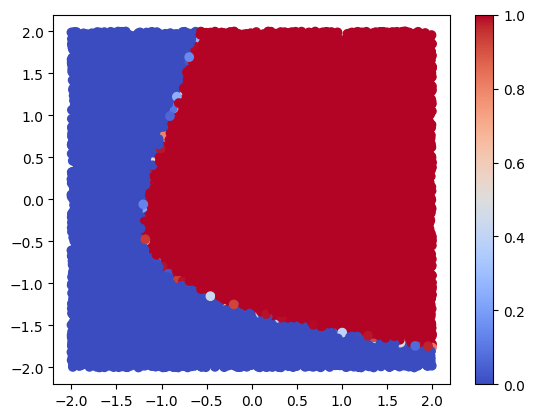

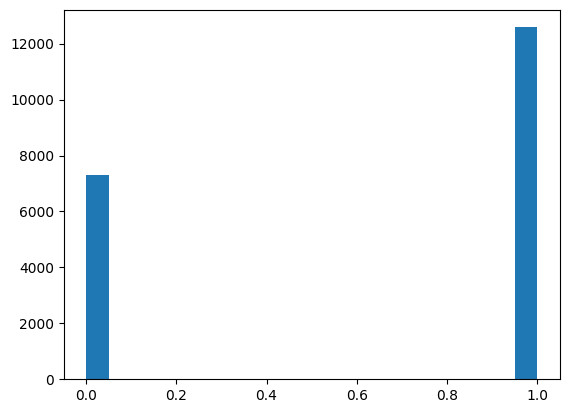

In [48]:
## net_custom_uniform
test_model(net_custom_uniform, dataset_uniform_test)

Accuracy: 0.8872500061988831


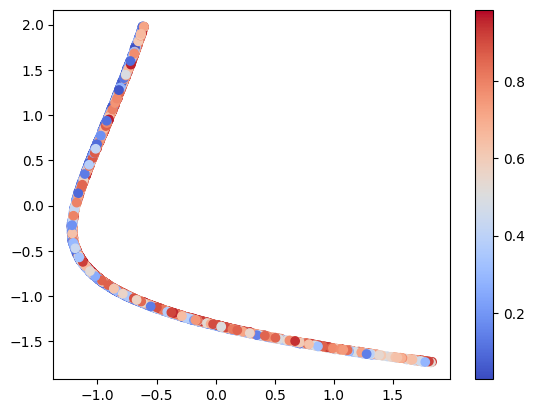

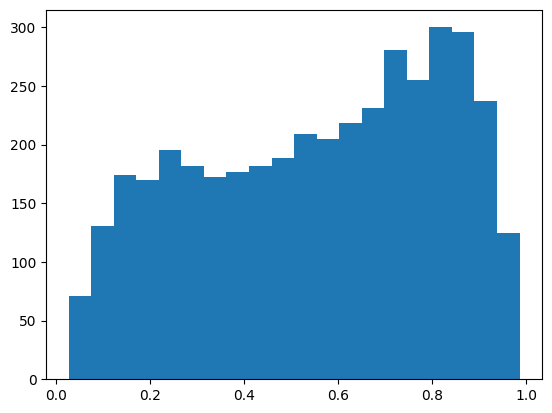

In [49]:
test_model(net_custom_uniform, dataset_near_test)

Accuracy: 0.9808750152587891


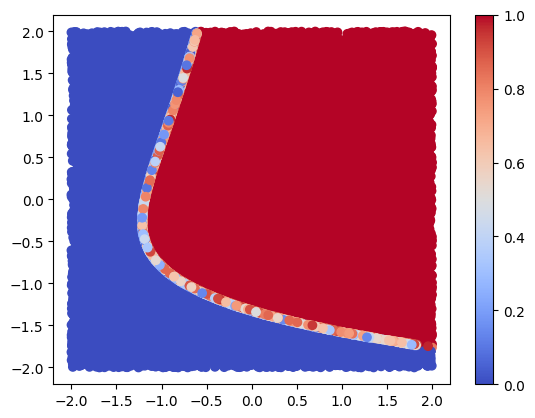

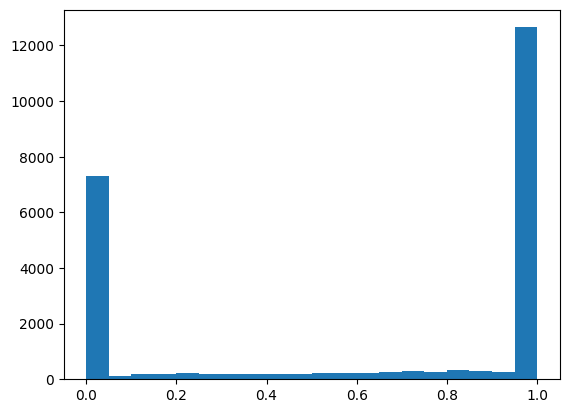

In [50]:
test_model(net_custom_uniform, dataset_merged_test)

Accuracy: 0.9995999932289124


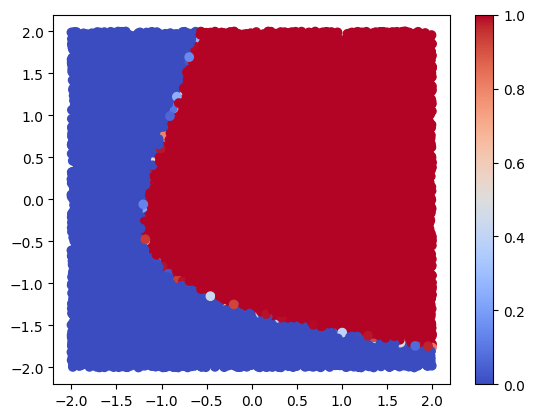

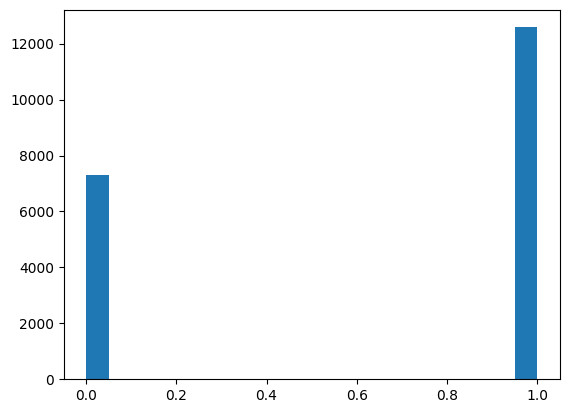

In [51]:
## net_bce_near
test_model(net_bce_near, dataset_uniform_test)

Accuracy: 0.8872500061988831


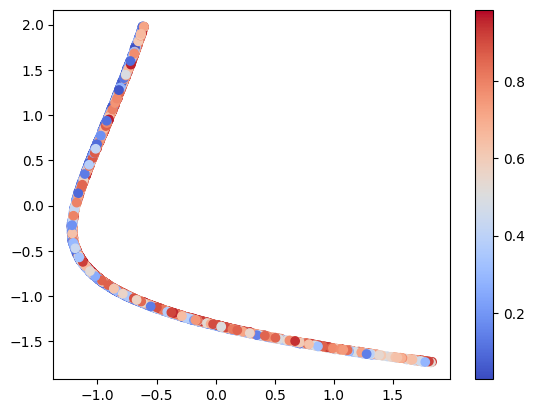

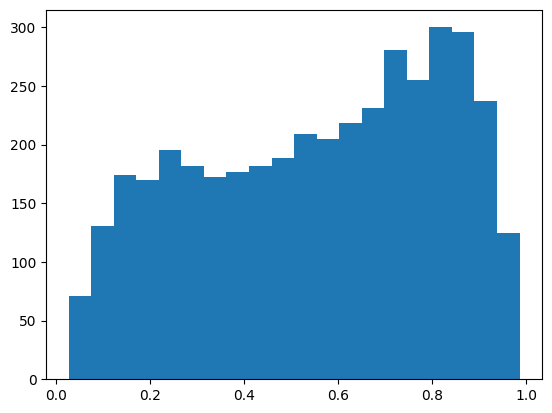

In [52]:
test_model(net_bce_near, dataset_near_test)

Accuracy: 0.9808750152587891


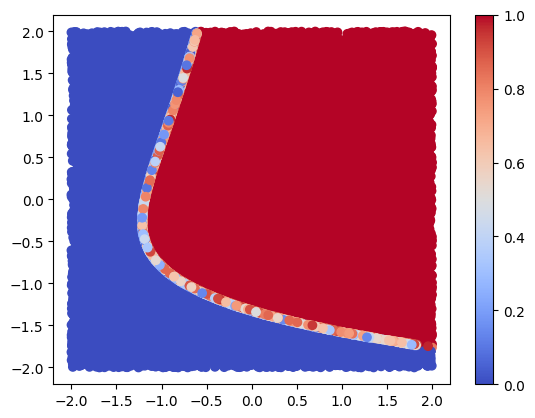

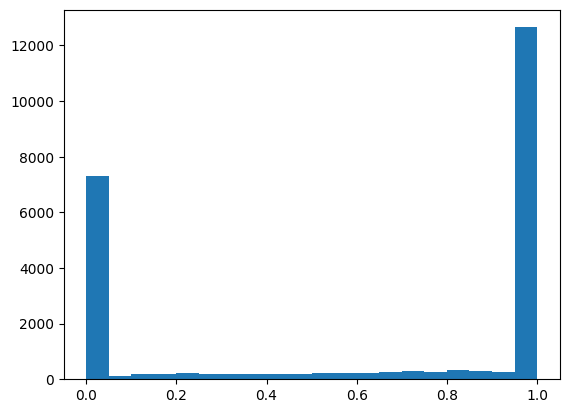

In [53]:
test_model(net_bce_near, dataset_merged_test)

Accuracy: 0.9995999932289124


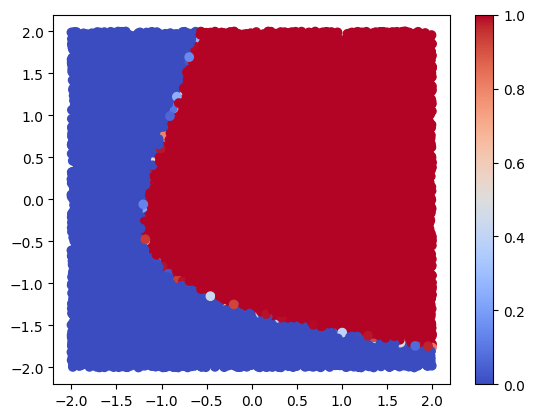

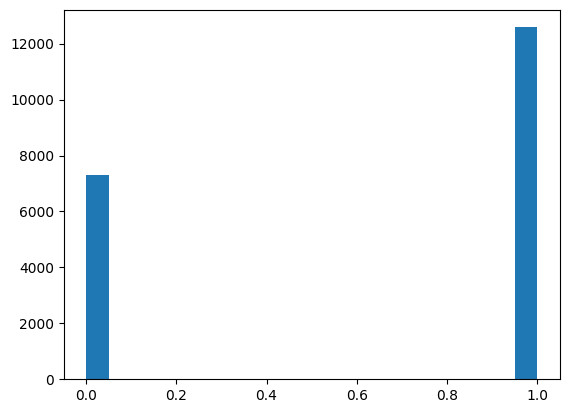

In [54]:
## net_custom_near
test_model(net_custom_near, dataset_uniform_test)

Accuracy: 0.8872500061988831


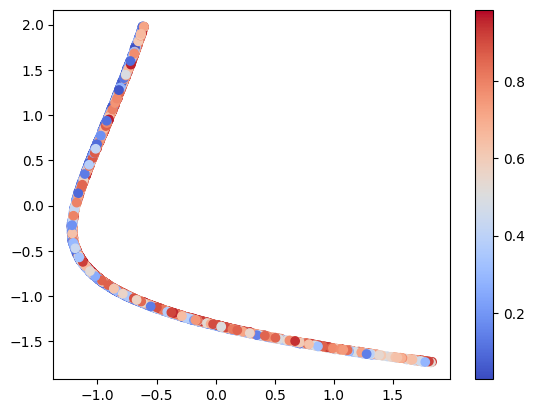

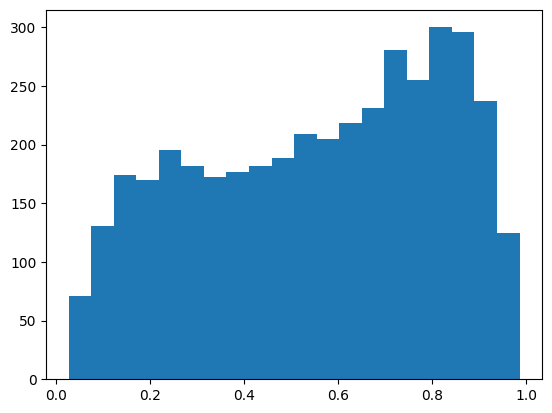

In [55]:
test_model(net_custom_near, dataset_near_test)

Accuracy: 0.9808750152587891


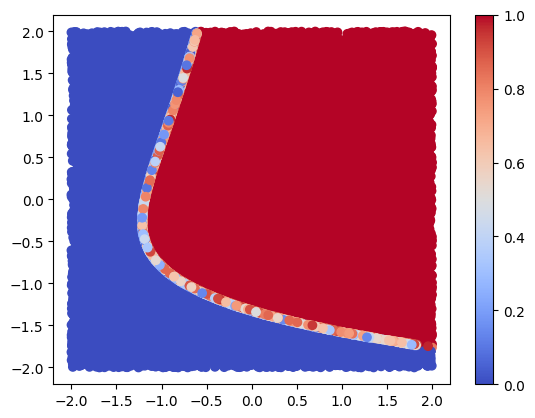

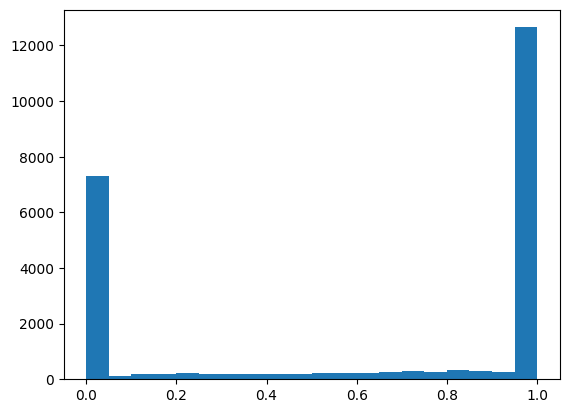

In [56]:
test_model(net_custom_near, dataset_merged_test)

Accuracy: 0.9995999932289124


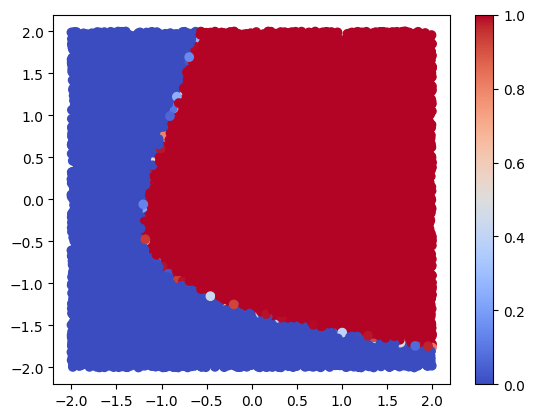

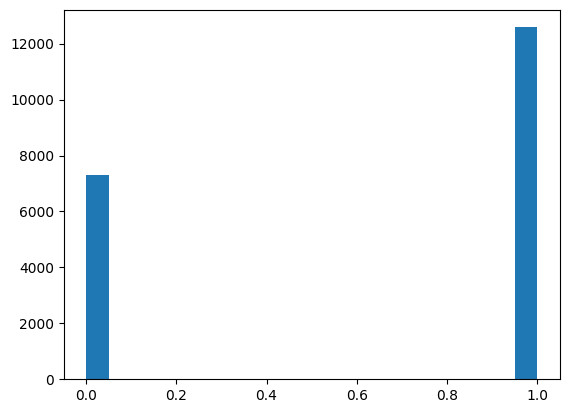

In [57]:
## net_bce_merged
test_model(net_bce_merged, dataset_uniform_test)

Accuracy: 0.8872500061988831


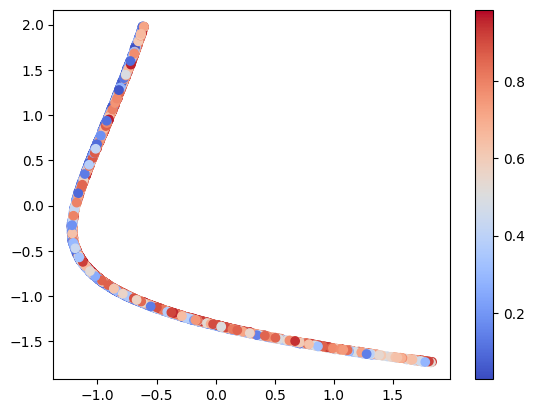

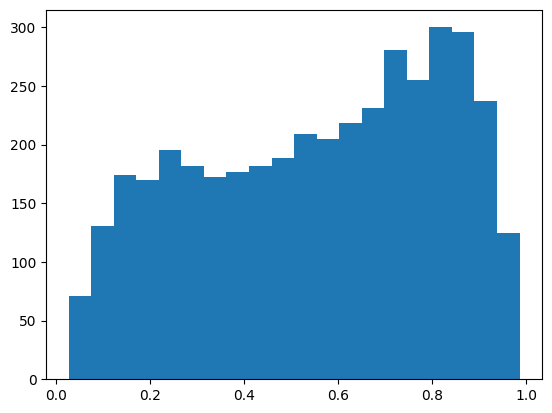

In [58]:
test_model(net_bce_merged, dataset_near_test)

Accuracy: 0.9808750152587891


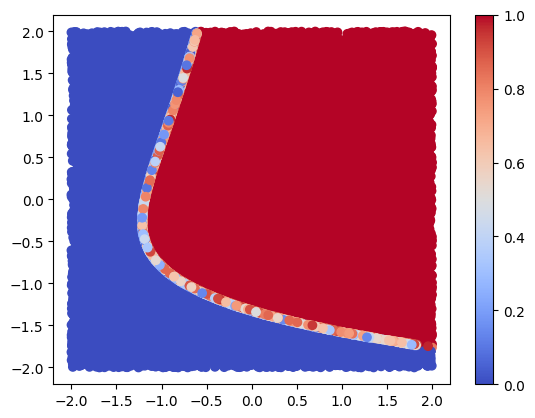

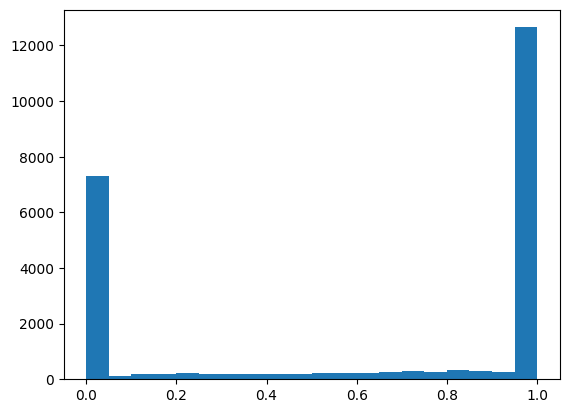

In [59]:
test_model(net_bce_merged, dataset_merged_test)

Accuracy: 0.9995999932289124


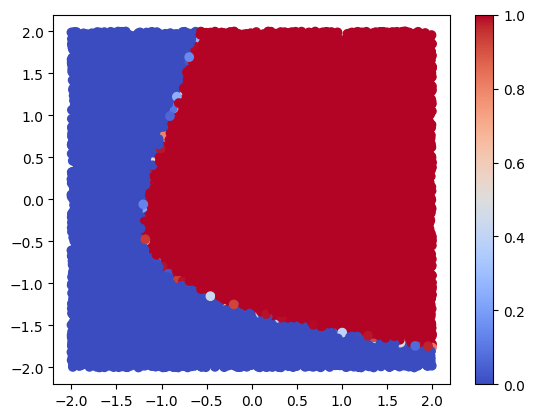

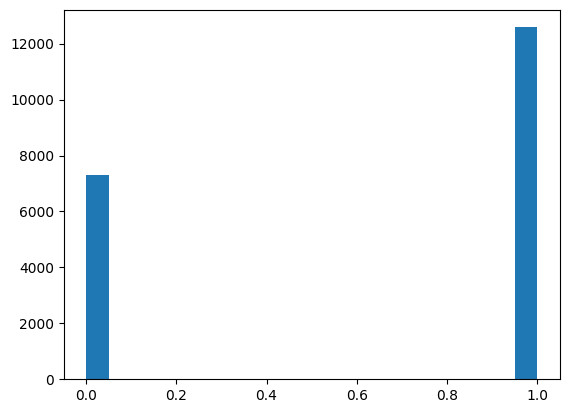

In [60]:
## net_custom_merged
test_model(net_custom_merged, dataset_uniform_test)

Accuracy: 0.8872500061988831


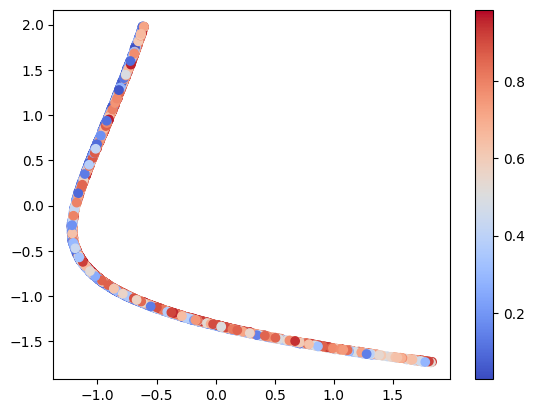

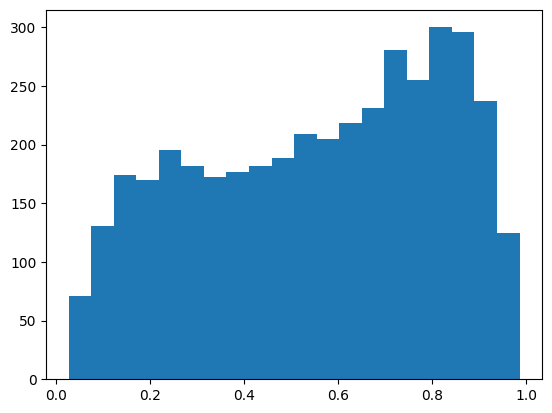

In [61]:
test_model(net_custom_merged, dataset_near_test)

Accuracy: 0.9808750152587891


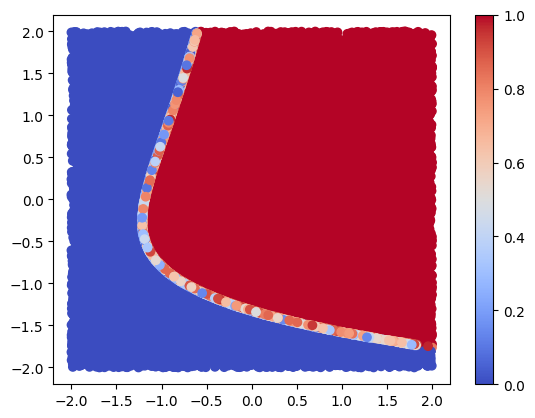

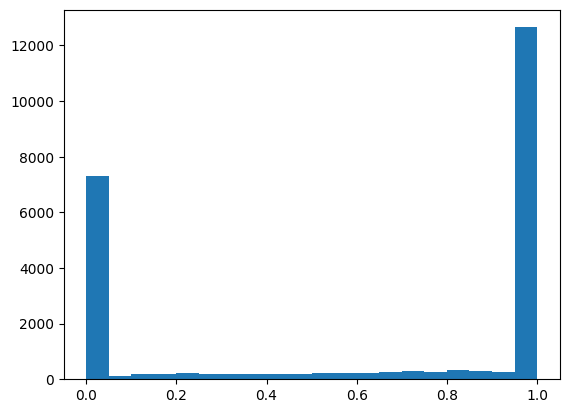

In [62]:
test_model(net_custom_merged, dataset_merged_test)